## Import Libraries

In [3]:
import os
import json
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew

## Extract features

In [85]:
def robust_template_matching(image, templates):
    """Robust template matching across different image sizes"""
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ncc_values = []
    for template in templates:
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        
        scales = [0.5, 0.75, 1.0, 1.25, 1.5]
        scale_ncc_values = []
        
        for scale in scales:
            resized_template = cv2.resize(
                template_gray, 
                (int(template_gray.shape[1] * scale), 
                 int(template_gray.shape[0] * scale)),
                interpolation=cv2.INTER_AREA
            )
            
            if resized_template.shape[0] > image_gray.shape[0] or \
               resized_template.shape[1] > image_gray.shape[1]:
                continue
            
            result = cv2.matchTemplate(
                image_gray, 
                resized_template, 
                cv2.TM_CCORR_NORMED
            )
            
            scale_ncc_values.append(np.max(result))
        
        ncc_values.append(max(scale_ncc_values) if scale_ncc_values else 0)
    
    return max(ncc_values)

class ImageFeatureExtractor:
    def __init__(self, templates):
        self.templates = templates
    
    def normalize_landscape(self, image):
        """Ensure image is in landscape orientation"""
        height, width = image.shape[:2]
        if height > width:
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        return image
    
    def color_features(self, image):
        """Extract color-based features"""
        image_float = image.astype(np.float32) / 255.0
        
        color_means = [np.mean(image_float[:,:,i]) for i in range(3)]
        
        thresholds = [0.25, 0.25, 0.25]
        highlight_percentages = [
            np.sum(image_float[:,:,i] > thresholds[i]) / image_float.size * 100 
            for i in range(3)
        ]
        
        return color_means + highlight_percentages
    
    def template_matching_feature(self, image):
        """Template matching feature extraction"""
        return robust_template_matching(image, self.templates)
    
    def advanced_features(self, image):
        """Extract advanced image features"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        saturation = np.mean(hsv[:,:,1])
        
        mean_intensity = np.mean(gray)
        intensity_variance = np.var(gray)
        
        glcm = graycomatrix(gray, [1], [0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0,0]
        correlation = graycoprops(glcm, 'correlation')[0,0]
        
        edges = cv2.Canny(gray, 100, 200)
        edge_density = np.sum(edges) / edges.size
        
        _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        highlight_features = {
            'area': sum(cv2.contourArea(cnt) for cnt in contours),
            'perimeter': sum(cv2.arcLength(cnt, True) for cnt in contours),
            'circularity': self._calculate_circularity(contours),
        }
        
        entropy = self._calculate_entropy(gray)
        skewness = skew(gray.flatten())
        
        return {
            'saturation': saturation,
            'mean_intensity': mean_intensity,
            'intensity_variance': intensity_variance,
            'contrast': contrast,
            'correlation': correlation,
            'edge_density': edge_density,
            'entropy': entropy,
            'skewness': skewness,
            **highlight_features
        }
    
    def _calculate_circularity(self, contours):
        """Calculate average circularity of highlight regions"""
        if not contours:
            return 0
        
        circularity_values = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter ** 2)
                circularity_values.append(circularity)
        
        return np.mean(circularity_values) if circularity_values else 0
    
    def _calculate_eccentricity(self, contours):
        """Calculate average eccentricity of highlight regions"""
        if not contours:
            return 0
        
        eccentricity_values = []
        for cnt in contours:
            (x,y), (MA,ma), angle = cv2.fitEllipse(cnt)
            eccentricity = np.sqrt(1 - (MA/ma)**2)
            eccentricity_values.append(eccentricity)
        
        return np.mean(eccentricity_values) if eccentricity_values else 0
    
    def _calculate_entropy(self, image):
        """Calculate image entropy"""
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = hist / np.sum(hist)
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        return entropy
    
    def extract_features(self, image):
        """Comprehensive feature extraction pipeline"""
        landscape_image = self.normalize_landscape(image)
        color_features = self.color_features(landscape_image)
        template_feature = self.template_matching_feature(landscape_image)
        advanced_features = self.advanced_features(landscape_image)
        return {
            'color_features': color_features,
            'template_matching_feature': template_feature,
            'advanced_features': advanced_features
        }

def extract_features_from_dataset(template_paths, dataset_path, output_csv_path):
    """Extract features from entire dataset"""

    templates = [cv2.imread(template) for template in template_paths]

    extractor = ImageFeatureExtractor(templates)

    all_features = []

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            
            try:
  
                image = cv2.imread(image_path)

                features = extractor.extract_features(image)

                flattened_features = (
                    features['color_features'] + 
                    [features['template_matching_feature']] + 
                    list(features['advanced_features'].values())
                )

                row = [class_name] + flattened_features
                all_features.append(row)
            
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    feature_names = (
        ['class'] + 
        [f'color_mean_{i}' for i in range(3)] + 
        [f'highlight_pct_{i}' for i in range(3)] + 
        ['template_match'] + 
        list(features['advanced_features'].keys())
    )

    df = pd.DataFrame(all_features, columns=feature_names)
    df.to_csv(output_csv_path, index=False)
    
    print(f"Features extracted and saved to {output_csv_path}")

template_paths = [
    r".\Our_Dataset\Templates\1.png",
    r".\Our_Dataset\Templates\2.png",
    r".\Our_Dataset\Templates\3.png",
    r".\Our_Dataset\Templates\4.png",
    r".\Our_Dataset\Templates\5.png",
]
dataset_path = r".\Our_Dataset\Cropped_Components"
OUTPUT_CSV_PATH = "features.csv"
target_size = (300, 300)

extract_features_from_dataset(template_paths, dataset_path, OUTPUT_CSV_PATH)

Features extracted and saved to features.csv


In [123]:
df = pd.read_csv("features.csv")
df

,class,color_mean_0,color_mean_1,color_mean_2,highlight_pct_0,highlight_pct_1,highlight_pct_2,template_match,saturation,mean_intensity,intensity_variance,contrast,correlation,edge_density,entropy,skewness,area,perimeter,circularity
0,Component Placing Problem,0.202388,0.116999,0.116462,9.375279,0.489365,4.669047,0.887857,181.843664,32.259772,231.348828,12.764097,0.972512,0.642905,5.727807,0.502027,0.0,0.000000,0.000000
1,Component Placing Problem,0.220247,0.090136,0.370050,12.082496,0.320605,20.054551,0.000000,190.834338,48.112475,498.751992,31.250362,0.968785,7.888674,6.014707,-0.091265,0.0,0.000000,0.000000
2,Component Placing Problem,0.224976,0.100617,0.336258,14.181036,0.561625,17.645123,0.810777,188.992694,47.245887,563.460535,40.436999,0.964253,8.273990,6.191177,0.552286,3.0,6.828427,0.808518
3,Component Placing Problem,0.173173,0.120334,0.178724,8.250166,1.166207,8.260632,0.803665,188.460136,36.653906,533.083744,70.667440,0.933948,12.284196,5.944207,1.693729,15.5,42.384776,0.132160
4,Component Placing Problem,0.178438,0.101312,0.212641,9.041474,0.618862,9.991072,0.795774,183.861273,36.556367,483.513562,32.184777,0.966928,13.675128,5.972470,0.848728,0.0,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,Wrong Component,0.184293,0.342823,0.399292,8.530493,17.285499,16.119403,0.916098,149.936558,87.106208,2956.921221,34.405547,0.994186,7.297860,6.691537,0.608962,7.5,35.071068,0.099392
3253,Wrong Component,0.162049,0.329390,0.385487,7.174811,16.527758,16.070970,0.953539,159.082913,83.398524,2868.554845,27.548745,0.995203,7.292983,6.719599,0.797403,26.0,92.769552,0.292706
3254,Wrong Component,0.163226,0.335332,0.363176,6.832043,17.524798,15.335421,0.938115,161.389540,82.623672,2839.922257,28.997736,0.994899,7.384781,6.791589,0.802399,14.0,82.769552,0.290462
3255,Wrong Component,0.280923,0.159385,0.237907,12.598271,3.832516,10.352503,0.893895,230.074657,50.146061,1053.636442,20.915507,0.990084,3.685594,6.474893,1.168979,446.0,954.406195,0.283386


## Binary Classifier


Binary Classification Metrics:
Best Parameters: {'n_estimators': 600, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}
Classification Report:
               precision    recall  f1-score   support

      Others       0.85      0.78      0.81       336
 Good Solder       0.78      0.85      0.82       316

    accuracy                           0.81       652
   macro avg       0.82      0.82      0.81       652
weighted avg       0.82      0.81      0.81       652



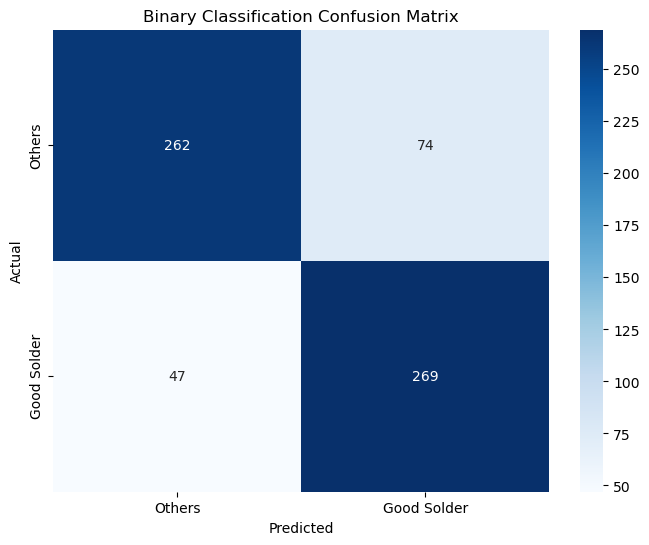

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Binary classification: Good Solder (1) vs Others (0)
df['binary_class'] = df['class'].apply(lambda x: 1 if x == 'Good Solder' else 0)

# Set up features (X) and target (y)
target_column = "binary_class"
X = df.drop(columns=["class", target_column])  # Exclude the original and binary target columns
y = df[target_column]

# Normalize the feature columns
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the normalized data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=40)

# Random Forest with Best Parameters
best_rf_params = {
    'n_estimators': 600,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

rf_model = RandomForestClassifier(**best_rf_params, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Metrics and Confusion Matrix
print("\nBinary Classification Metrics:")
print("Best Parameters:", best_rf_params)
print("Classification Report:\n", classification_report(y_test, rf_predictions, target_names=["Others", "Good Solder"]))
plot_confusion_matrix(y_test, rf_predictions, labels=["Others", "Good Solder"], title="Binary Classification Confusion Matrix")


In [101]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Class-to-Integer Mapping:", class_mapping)

Class-to-Integer Mapping: {'Component Placing Problem': 0, 'Good Solder': 1, 'Improper Solder': 2, 'Missing Component': 3, 'Tombstone': 4, 'Unknown fault': 5, 'Wrong Component': 6}


## Random Forest 


Random Forest Metrics:
Best Parameters: {'n_estimators': 600, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.36      0.42       102
           1       0.73      0.93      0.82       326
           2       0.56      0.28      0.38       113
           3       0.93      0.89      0.91        84
           4       0.00      0.00      0.00         5
           5       0.81      0.93      0.87        14

    accuracy                           0.71       644
   macro avg       0.59      0.57      0.56       644
weighted avg       0.69      0.71      0.68       644



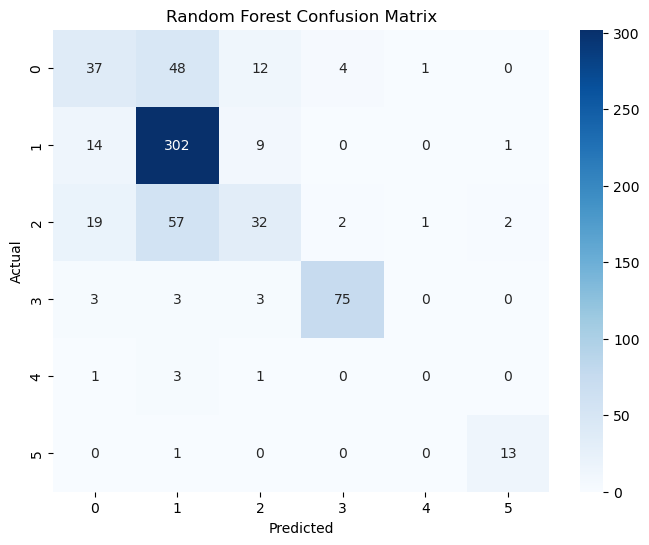

In [17]:
target_column = "class"
X = df.drop(columns=[target_column])
y = df[target_column]

# Normalize the feature columns
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the normalized data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=40)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Random Forest with Best Parameters
best_rf_params = {
    'n_estimators': 600,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

rf_model = RandomForestClassifier(**best_rf_params, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Random Forest Metrics
print("\nRandom Forest Metrics:")
print("Best Parameters:", best_rf_params)
print("Classification Report:\n", classification_report(y_test, rf_predictions))
plot_confusion_matrix(y_test, rf_predictions, labels=np.unique(y), title="Random Forest Confusion Matrix")

## SVM Classifier

Best SVM Metrics:
{'C': 100, 'kernel': 'rbf', 'gamma': 0.01, 'class_weight': None, 'random_state': 42}
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.40      0.46       102
           1       0.73      0.94      0.82       326
           2       0.48      0.19      0.28       113
           3       0.94      0.87      0.90        84
           4       0.00      0.00      0.00         5
           5       0.75      0.86      0.80        14

    accuracy                           0.71       644
   macro avg       0.57      0.54      0.54       644
weighted avg       0.67      0.71      0.67       644



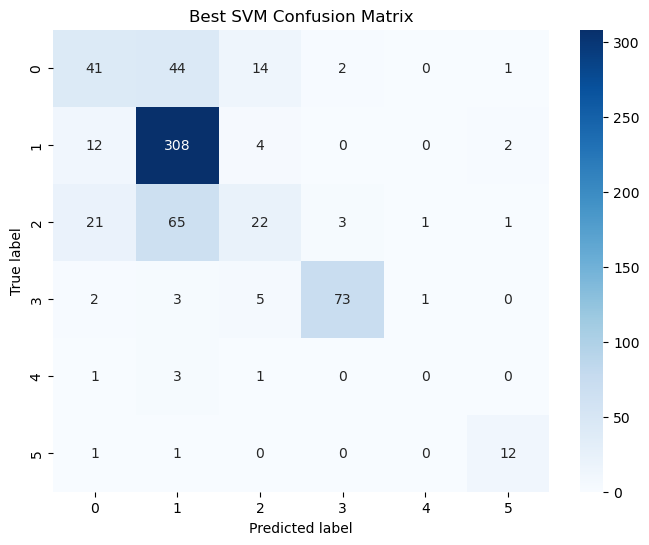

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Best hyperparameters from grid search
best_svm_params = {
    'C': 100,  # Regularization parameter
    'kernel': 'rbf',  # Kernel type
    'gamma': 0.01,  # Kernel coefficient
    'class_weight': None,  # No class weighting
    'random_state': 42  # Random seed for reproducibility
}

# Initialize the SVM model with the best parameters
best_svm_model = SVC(**best_svm_params)

# Train the SVM model
best_svm_model.fit(X_train, y_train)

# Make predictions using the best model
best_svm_predictions = best_svm_model.predict(X_test)

# Print classification report
print("Best SVM Metrics:")
print(best_svm_params)
print("Classification Report:\n", classification_report(y_test, best_svm_predictions))

# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_test, best_svm_predictions, labels=np.unique(y), title="Best SVM Confusion Matrix")

## Simple ANN Classifier

Epoch 1/350


C:\Users\omcch\anaconda3\envs\ml_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3657 - loss: 1.5729 - val_accuracy: 0.5450 - val_loss: 1.2131
Epoch 2/350
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5733 - loss: 1.1424 - val_accuracy: 0.5807 - val_loss: 1.0764
Epoch 3/350
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6110 - loss: 1.0210 - val_accuracy: 0.6040 - val_loss: 1.0065
Epoch 4/350
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6306 - loss: 0.9837 - val_accuracy: 0.5994 - val_loss: 0.9867
Epoch 5/350
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6406 - loss: 0.9173 - val_accuracy: 0.6227 - val_loss: 0.9656
Epoch 6/350
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6584 - loss: 0.8933 - val_accuracy: 0.6273 - val_loss: 0.9482
Epoch 7/350
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6544 - loss: 0.9167 - val_accuracy: 0.6304 - val_loss: 0.9310
Epoch 8/350
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6517 - loss: 0.8647 - val_accuracy: 0.6165 - val_loss: 0.9

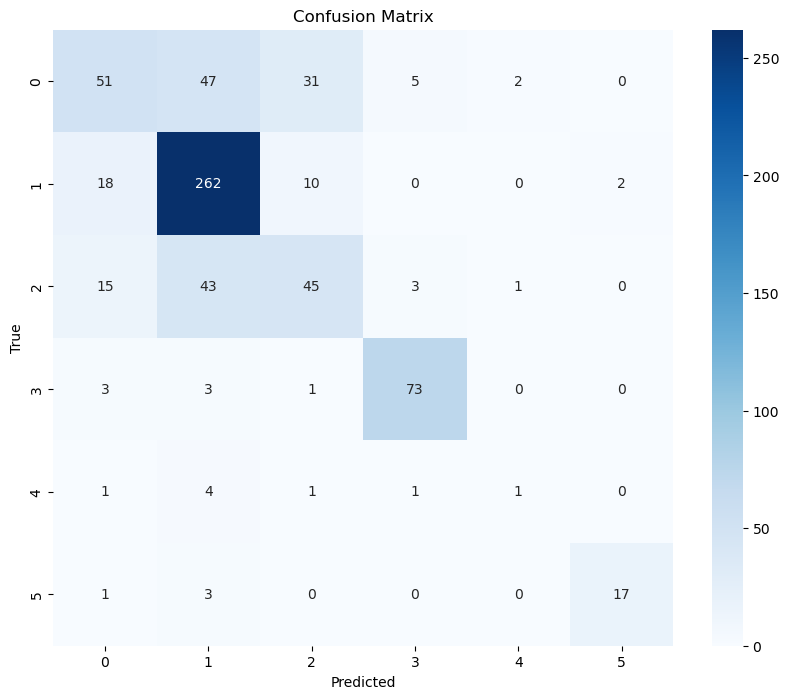

In [63]:
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

target_column = "class"
X = df.drop(columns=[target_column])
y = df[target_column]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define the FNN architecture
def build_fnn(input_shape, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)), 
        Dropout(0.2),
         Dense(64, activation='relu'), 
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)

# Build the FNN model
input_shape = X_train.shape[1]
num_classes = len(label_encoder.classes_)
fnn_model = build_fnn(input_shape, num_classes)

history = fnn_model.fit(
    X_train, y_train_onehot,
    epochs=350,
    batch_size=32,
    validation_data=(X_test, y_test_onehot), 
    verbose=1,
    callbacks=[early_stopping]  
)


# Evaluate the FNN model on the test set
test_loss, test_accuracy = fnn_model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


# Predict the labels for the test set
y_pred = fnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Calculate accuracy, recall, and F1 score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()